In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from prophet import Prophet
import seaborn as sns
import statsmodels.api as sm
from math import sqrt

from sklearn.preprocessing import power_transform
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn')

from src.time_series_functions import *

In [2]:
base_df = csv_with_datetime('data/combdf_snoflow_and_cfs1.csv', 'Unnamed: 0')

In [3]:
df = base_df.copy()


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11431 entries, 1990-01-01 to 2021-04-18
Data columns (total 8 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Snow Water Equivalent (in) Start of Day Values       11431 non-null  float64       
 1   Precipitation Accumulation (in) Start of Day Values  11431 non-null  float64       
 2   Air Temperature Maximum (degF)                       11275 non-null  float64       
 3   Air Temperature Minimum (degF)                       11249 non-null  float64       
 4   Air Temperature Average (degF)                       11266 non-null  float64       
 5   Precipitation Increment (in)                         11429 non-null  float64       
 6   Streamflow Value                                     11431 non-null  float64       
 7   ds                                                   11431 non-null  

<AxesSubplot:xlabel='ds', ylabel='Streamflow Value'>

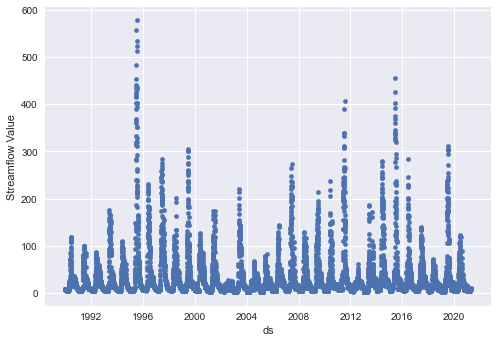

In [5]:
df.plot.scatter(x='ds', y='Streamflow Value')

In [6]:
#Domain knowledge: confirmed that 600cfs is not unreasonable, 
# 1200CFS is considered safe for humans to wade in and out of water. 

<AxesSubplot:xlabel='ds', ylabel='Air Temperature Average (degF)'>

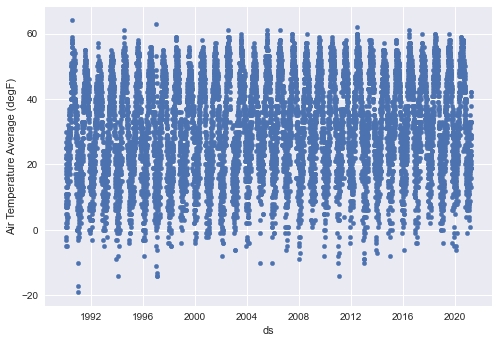

In [7]:
df.plot.scatter(x='ds', y='Air Temperature Average (degF)')

In [8]:
#NaNs in temperature data not from one specific chunk of time, need to locate them

In [9]:
del_df = df[df['Air Temperature Average (degF)'].isnull()]

<AxesSubplot:xlabel='ds', ylabel='Streamflow Value'>

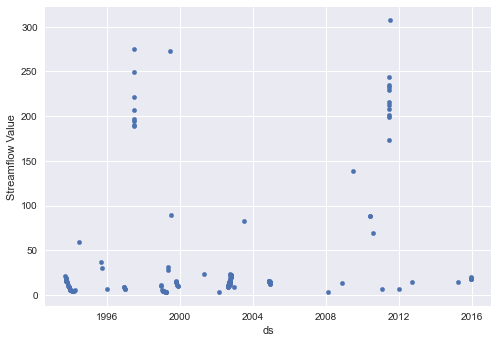

In [10]:
del_df.plot.scatter(x='ds', y='Streamflow Value')

In [11]:
#small % of records containing NaNs, randomly distributed. using ffill. 
df.fillna(method='ffill', inplace=True)

In [12]:
#preparing dataframe for multivariate Prophet model, starting with avg daily temp. 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11431 entries, 1990-01-01 to 2021-04-18
Data columns (total 8 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Snow Water Equivalent (in) Start of Day Values       11431 non-null  float64       
 1   Precipitation Accumulation (in) Start of Day Values  11431 non-null  float64       
 2   Air Temperature Maximum (degF)                       11431 non-null  float64       
 3   Air Temperature Minimum (degF)                       11431 non-null  float64       
 4   Air Temperature Average (degF)                       11431 non-null  float64       
 5   Precipitation Increment (in)                         11431 non-null  float64       
 6   Streamflow Value                                     11431 non-null  float64       
 7   ds                                                   11431 non-null  

In [14]:
mvar_1_df = df[['ds', 'Streamflow Value', 'Air Temperature Average (degF)']]

In [15]:
mvar_1_df.columns = ['ds', 'y', 'avg_temp']

In [16]:
mvar_1_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11431 entries, 1990-01-01 to 2021-04-18
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        11431 non-null  datetime64[ns]
 1   y         11431 non-null  float64       
 2   avg_temp  11431 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 357.2 KB


In [17]:
#separating train (1990-2019) and test (2020) data
X_train = mvar_1_df['1990':'2019']
X_test = mvar_1_df['2020']

In [18]:
#ready to go, instantiate Prophet model and add additional regressor: 

m = Prophet(interval_width = 0.95, yearly_seasonality=True)
m = m.add_regressor('avg_temp')

In [19]:
#fit model on training data
model = m.fit(X_train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
# is this method different from previous creation of forecast table? compare results. 
predictions = model.predict(X_test.drop('y', axis=1))


In [21]:
rmse = sqrt(mean_squared_error(X_test['y'], predictions['yhat']))
rmse

23.06538756710128

In [22]:
#this is attempting to predict an entire year. Try the process again to just predict 30 days: 

In [23]:
X_train_30_day = mvar_1_df['1990-01-01':'2020-05-30']
X_test_30_day = mvar_1_df['2020-06-01':'2020-06-30']

In [24]:
m2 = Prophet(interval_width = 0.95, yearly_seasonality=True)
m2 = m2.add_regressor('avg_temp')
model = m2.fit(X_train_30_day)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [25]:
pred_30_day = model.predict(X_test_30_day.drop(columns='y'))

In [26]:
rmse = sqrt(mean_squared_error(X_test_30_day['y'], pred_30_day['yhat']))
rmse

55.18058978538414

In [27]:
#model is worse predicting shorter time range? Possibly due to dependability of winter flows? 

In [28]:
#functionize the testing process to test additional regressors in one-year window

In [29]:
mvar_2_df = df[['ds', 'Streamflow Value', 'Air Temperature Average (degF)', 'Precipitation Accumulation (in) Start of Day Values' ]]

In [30]:
mvar_2_df.columns = ['ds', 'y', 'avg_temp', 'precip_accum']

In [31]:
m3 = prophet_add_regressors(['avg_temp', 'precip_accum'])

In [32]:
split_fit_predict(m3, mvar_2_df, '1990', '2019', '2020', '2020')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum'], dtype='object') = 22.97013850836223


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,avg_temp,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,23.431094,-55.829316,64.448349,23.431094,23.431094,-18.811974,-18.811974,-18.811974,0.448734,...,-0.039822,-0.039822,-0.039822,6.821020,6.821020,6.821020,0.0,0.0,0.0,4.619120
1,2020-01-02,23.426703,-57.316719,64.848334,23.426703,23.426703,-18.425027,-18.425027,-18.425027,0.723550,...,0.160701,0.160701,0.160701,5.983828,5.983828,5.983828,0.0,0.0,0.0,5.001676
2,2020-01-03,23.422311,-57.004839,64.281043,23.422311,23.422311,-19.345092,-19.345092,-19.345092,0.654846,...,0.165768,0.165768,0.165768,5.127400,5.127400,5.127400,0.0,0.0,0.0,4.077219
3,2020-01-04,23.417920,-56.650684,69.893948,23.417920,23.417920,-20.518610,-20.518610,-20.518610,0.242621,...,-0.108085,-0.108085,-0.108085,4.265560,4.265560,4.265560,0.0,0.0,0.0,2.899310
4,2020-01-05,23.413528,-59.956060,65.889689,23.413528,23.413528,-21.190616,-21.190616,-21.190616,0.380029,...,-0.064213,-0.064213,-0.064213,3.412274,3.412274,3.412274,0.0,0.0,0.0,2.222913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2020-12-27,21.845799,-65.942397,59.117069,20.593867,23.480293,-27.927218,-27.927218,-27.927218,0.654846,...,-0.064213,-0.064213,-0.064213,9.879240,9.879240,9.879240,0.0,0.0,0.0,-6.081419
362,2020-12-28,21.841408,-70.648608,54.052060,20.583737,23.483661,-28.269105,-28.269105,-28.269105,0.654846,...,-0.157869,-0.157869,-0.157869,9.256610,9.256610,9.256610,0.0,0.0,0.0,-6.427697
363,2020-12-29,21.837016,-65.811016,58.082824,20.573607,23.487029,-27.121846,-27.121846,-27.121846,0.792254,...,0.043519,0.043519,0.043519,8.567474,8.567474,8.567474,0.0,0.0,0.0,-5.284829
364,2020-12-30,21.832625,-68.754085,57.306950,20.563477,23.490397,-27.849222,-27.849222,-27.849222,0.895310,...,-0.039822,-0.039822,-0.039822,7.820383,7.820383,7.820383,0.0,0.0,0.0,-6.016597


In [33]:
mvar_3_df = df[['ds', 'Streamflow Value', 'Air Temperature Average (degF)',\
                'Precipitation Accumulation (in) Start of Day Values',\
                'Snow Water Equivalent (in) Start of Day Values']]

In [34]:
mvar_3_df.columns = ['ds', 'y', 'avg_temp', 'precip_accum', 'swe']

In [50]:
m33 = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])

In [51]:
pred = split_fit_predict(m33, mvar_3_df, '1990', '2019', '2020', '2020')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 23.400694736897382


In [37]:
#model gets WORSE when adding in snow water equivalent

In [54]:
X_test = mvar_3_df['2020':'2020']

In [40]:
average_year = mvar_3_df.groupby([mvar_3_df.index.month, mvar_3_df.index.day]).mean()

In [64]:
rmse = sqrt(mean_squared_error(X_test['y'], average_year['y']))
benchmark = rmse
benchmark

23.1601596054826

In [ ]:
#Using 30 years training data, only able to create 0.8% lift compared to historical average.

In [38]:
#expirimenting with adding LESS training data:

In [56]:
#20 years
m3a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3a = archive_split_fit_predict(m3a, mvar_3_df, '2000', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 21.913036301176643


21.913036301176643

In [57]:
#10 years
m3b = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3b = archive_split_fit_predict(m3b, mvar_3_df, '2010', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3b['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 31.37701834161609


31.37701834161609

In [58]:
#5 years
m3c = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3c = archive_split_fit_predict(m3c, mvar_3_df, '2015', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3c['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 43.72089203287908


43.72089203287908

In [59]:
#3 years
m3d = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3d = archive_split_fit_predict(m3d, mvar_3_df, '2017', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3d['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 39.87781080084596


39.87781080084596

In [60]:
#1 years
m3e = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3e = archive_split_fit_predict(m3e, mvar_3_df, '2019', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3e['yhat']))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 185.18160055017185


185.18160055017185

In [62]:
#best results at 20 years... experimenting with a few more combos between 30 and 20 to try and find a sweet spot
#1995 black swan year.  Trying 25 years 1996-2019
m3f = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3f = archive_split_fit_predict(m3f, mvar_3_df, '1996', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3f['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 22.742216479236486


22.742216479236486

In [65]:
#20 year window still best performer. Trying two more combos: 
#22 years
m3g = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3g = archive_split_fit_predict(m3g, mvar_3_df, '1998', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3g['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 22.513961852836932


22.513961852836932

In [67]:
#15 years
m3h = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3h = archive_split_fit_predict(m3h, mvar_3_df, '2005', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3h['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 25.618911256092144


25.618911256092144

In [68]:
#20 years sweet spot
m3a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
pred3a = archive_split_fit_predict(m3a, mvar_3_df, '2000', '2019', '2020', '2020')
sqrt(mean_squared_error(X_test['y'], pred3a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 21.913036301176643


21.913036301176643

In [73]:
#sliding 20 year window back at two intervals to see performance - drop leap years 
m4a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
mvar_4_df = mvar_3_df[mvar_3_df['ds']!='02-29']
X_test = mvar_4_df['2019':'2019']
pred4a = archive_split_fit_predict(m4a, mvar_4_df, '1999', '2018', '2019', '2019')
sqrt(mean_squared_error(X_test['y'], pred4a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 42.31603851753898


42.31603851753898

In [74]:
#ouch. Testing prediction for 2018:
m4a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
mvar_4_df = mvar_3_df[mvar_3_df['ds']!='02-29']
X_test = mvar_4_df['2018':'2018']
pred4a = archive_split_fit_predict(m4a, mvar_4_df, '1998', '2017', '2018', '2018')
sqrt(mean_squared_error(X_test['y'], pred4a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 24.314949210903425


24.314949210903425

In [75]:
#More reasonable. Testing prediction for 2017:
m4a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
mvar_4_df = mvar_3_df[mvar_3_df['ds']!='02-29']
X_test = mvar_4_df['2017':'2017']
pred4a = archive_split_fit_predict(m4a, mvar_4_df, '1997', '2016', '2017', '2017')
sqrt(mean_squared_error(X_test['y'], pred4a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 17.75937225683719


17.75937225683719

In [ ]:
# ^^ best performane yet. Seems like model really struggles with outlier years. 


In [76]:
#should test on most recent leap year (2016) to see if issues arise. 
m4a = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
mvar_4_df = mvar_3_df[mvar_3_df['ds']!='02-29']
X_test = mvar_4_df['2016':'2016']
pred4a = archive_split_fit_predict(m4a, mvar_4_df, '1996', '2015', '2016', '2016')
sqrt(mean_squared_error(X_test['y'], pred4a['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE Index(['ds', 'y', 'avg_temp', 'precip_accum', 'swe'], dtype='object') = 24.236403252686916


24.236403252686916

In [2]:
## circling back on Prophet models to collect graphs
prophet = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
#load in master df
base_df = csv_with_datetime('data/master_df.csv', 'ds')
df = base_df.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
prophet_df = df['1990':'2020'].copy()

In [3]:
prophet_df['ds'] = prophet_df.index

In [13]:
def split_fit_predict(df, test_low, test_upper):
    model = prophet_add_regressors(['avg_temp', 'precip_accum', 'swe'])
    working_df = df.copy()
    working_df = working_df[:test_upper]
    X_train = df[-6000:]
    X_test = df[test_low:test_upper]
    model = model.fit(X_train)
    pred = model.predict(X_test.drop(columns=['y', 'hist_avg_y']))
    rmse = sqrt(mean_squared_error(X_test['y'], pred['yhat']))
    print (f'RMSE {test_upper} = {rmse}')
    return pred, rmse

In [18]:
pred, rmse = split_fit_predict(prophet_df, '2019', '2019')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE 2019 = 37.09167517732505
